# Ground-based search

In [1]:
# in order to run on all CPUs
import os
import jax

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

## The dataset

For this tutorial, we will load a simulated dataset that consists in 5 nights of observation from a ground-based telescope.

In [2]:
import numpy as np
from nuance.utils import simulated_ground_based

observations, true = simulated_ground_based(N=5)

/opt/homebrew/Caskroom/miniforge/base/envs/nuance/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The `observations` object is a list of dictionaries that contain both the time and fluxes of each observation together with some simultaneous measurements

In [3]:
observations[0].keys()

dict_keys(['time', 'flux', 'error', 'airmass', 'bkg', 'fwhm'])

Let's plot these observations

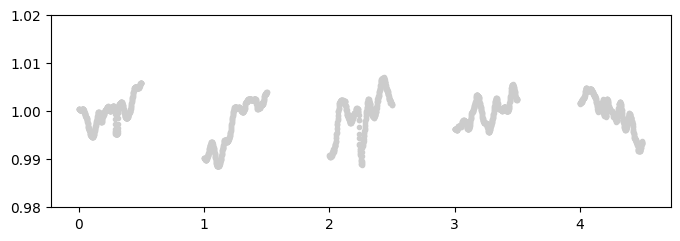

In [4]:
import matplotlib.pyplot as plt

time = np.concatenate([data["time"] for data in observations])
flux = np.concatenate([data["flux"] for data in observations])

plt.figure(figsize=(8, 2.5))
plt.plot(time, flux, ".", c="0.8")
_ = plt.ylim(0.98, 1.02)

## Fitting the GP

As usual, we start by defining a Gaussian Process (GP) that can model the covariance of the data, in this case mostly associated with stellar variability. We choose an SHO kernel that we fit on the global light curve

In [5]:
import tinygp
from nuance.core import gp_model
from nuance.utils import minimize

mean_error = np.mean([data["error"] for data in observations])


def build_gp(params, time=time):
    kernel = tinygp.kernels.quasisep.SHO(**params)
    return tinygp.GaussianProcess(kernel, time, diag=mean_error**2, mean=0.0)


initial_params = {"omega": 5.0, "quality": 5.0, "sigma": 0.02}

mu, nll = gp_model(time, flux, build_gp)
gp_params = minimize(nll, initial_params)

Let see the result

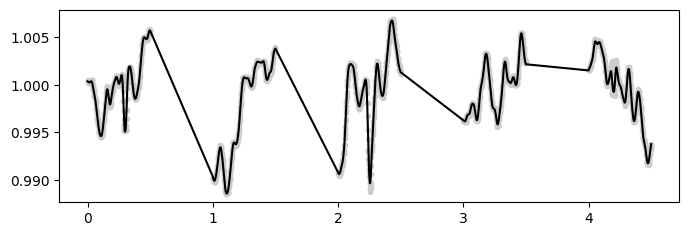

In [6]:
plt.figure(figsize=(8, 2.5))
plt.plot(time, flux, ".", c="0.8")
_ = plt.plot(time, mu(gp_params), c="k")

We note that we completely ignored the presence of systematic signals, using a `0` mean GP that will naturally be non-optimal (but we only know that because we simulated the dataset).

## Linear search(es)

We can now use the kernel optimized in the last section to define the `Nuance` object of each observation, and run each linear search separately. We can also build each observation design matrix `X` based on the *airmass*, *bkg*, *fwhm* contemporaneous measurements.

In [7]:
from nuance import Nuance

Xs = [
    np.vstack([np.ones_like(data["time"]), data["airmass"], data["bkg"], data["fwhm"]])
    for data in observations
]

gps = [build_gp(gp_params, data["time"]) for data in observations]

nus = [
    Nuance(data["time"], data["flux"], gp=gps[i], X=Xs[i])
    for i, data in enumerate(observations)
]

for nu in nus:
    t0s = nu.time.copy()
    Ds = np.linspace(0.01, 0.1, 5)
    nu.linear_search(t0s, Ds)

100%|██████████| 510/510 [00:00<00:00, 1564.62it/s]


## Periodic search

Let's combine these linear searches into a `CombinedNuance` object and perform the periodic search

In [8]:
from nuance import CombinedNuance

nu = CombinedNuance(nus)

periods = np.linspace(0.2, 5.0, 5000)
search = nu.periodic_search(periods)

100%|██████████| 5000/5000 [00:14<00:00, 341.23it/s]


## Results

Let's look at the results

	true	found
t0	0.299	0.300 days
D	0.033	0.026 days
P	0.650	0.650 days


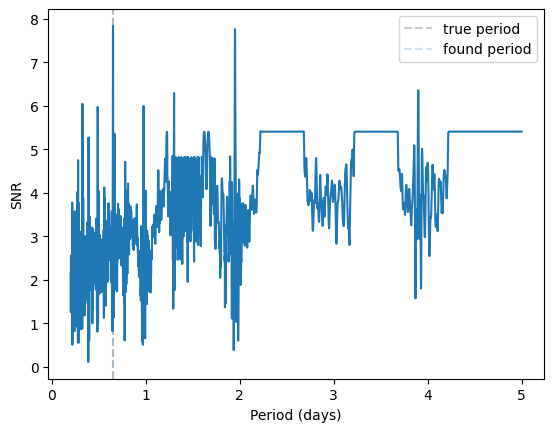

In [9]:
t0, D, P = search.best
found = {"t0": t0, "D": D, "P": P}

print(f"\ttrue\tfound")
for param in ["t0", "D", "P"]:
    print(f"{param}\t{found[param]:.3f}\t{(true['transit_params'])[param]:.3f} days")

plt.axvline(true["transit_params"]["P"], ls="--", c="k", alpha=0.2, label="true period")
plt.axvline(found["P"], ls="--", c="C0", alpha=0.2, label="found period")

plt.plot(periods, search.Q_snr)
plt.xlabel("Period (days)")
plt.ylabel("SNR")
_ = plt.legend()

Looking at this periodogram, it seems we could also have detected an alias of the true transit period (see the second peak). However, if we plot the found signal against the true transit, we notice that both periods are actually very representative of the data we have, given most transits were actually not observed.

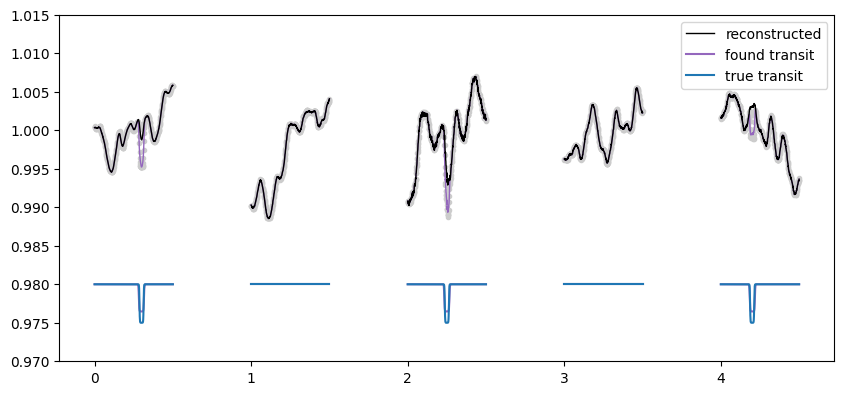

In [10]:
found_signals = np.array(nu.models(*search.best, split=True))

plt.figure(figsize=(10, 4.5))
plt.plot(time, flux, ".", c="0.8")
for i in range(len(observations)):
    systematics, transit, variability = found_signals[:, i, :]
    plt.plot(nu[i].time, systematics + variability + transit, c="C4", lw=1)
    plt.plot(
        nu[i].time,
        systematics + variability,
        c="k",
        lw=1,
        label="reconstructed" if i == 0 else None,
    )

for i in range(len(observations)):
    plt.plot(
        nu[i].time,
        found_signals[1, i, :] + 1 - 0.02,
        c="C4",
        label="found transit" if i == 0 else None,
    )
    plt.plot(
        nu[i].time,
        true["transits"][i] + 1 - 0.02,
        c="C0",
        label="true transit" if i == 0 else None,
    )
plt.ylim(0.97, 1.015)
plt.legend()

We note that the transit we found has a shallower depth than the simulated one, but the fact that a detection was possible in such levels of correlated noise (and with a non-optimal GP) is satisfying.